In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets
from ipywidgets import widgets
import time

from run_simulation import invasion_main

# Running and Visualizing One Simulation

In [2]:
weeks_run = 15
simulation_df = invasion_main(weeks_run) # Change this to change the number of weeks
# print(type(simulation_df))
simulation_df

,County,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7,Week 8,Week 9,Week 10,Week 11,Week 12,Week 13,Week 14,Week 15
0,Cook,0.1,0.145319,0.202675,0.312213,0.577794,0.960084,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
1,DuPage,0.0,0.080313,0.048442,0.183024,0.374689,0.951912,1.000000,0.972228,1.000000,1.000000,1.000000,1.000000,0.790879,1.000000,1.00000,1.000000
2,Kane,0.3,0.342222,0.346127,0.381301,0.720009,1.000000,1.000000,0.636147,0.663400,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
3,Will,0.0,0.053006,0.040083,0.120139,0.330124,0.462167,0.639081,1.000000,1.000000,1.000000,1.000000,1.000000,0.817410,1.000000,1.00000,1.000000
4,Winnebago,0.0,0.265602,0.460227,0.986947,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.95575,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,-0.000003,-0.000075,0.000270,0.000052,0.003995,0.044104,0.168711,0.699674,0.809977,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
98,Calhoun,0.0,0.014662,0.070563,0.062639,0.209031,0.635500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
99,Schuyler,0.0,0.000019,0.000067,0.002445,0.006903,0.006505,0.011456,0.226167,0.393595,0.861059,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
100,Gallatin,0.0,-0.000004,-0.000796,-0.000761,0.001174,0.019047,0.035957,0.104886,0.126318,0.144013,0.284865,0.483105,0.972695,1.000000,1.00000,0.381190


In [3]:
def make_visual_df(simulation_df):
    visual_df = simulation_df.T
    visual_df.columns = visual_df.iloc[0]
    visual_df = visual_df.drop(visual_df.index[0])
    return visual_df

visual_df = make_visual_df(simulation_df)
visual_df

County,Cook,DuPage,Kane,Will,Winnebago,Lake,McHenry,St. Clair,Kendall,Madison,...,Scott,Stark,Jasper,Hamilton,Pike,Henderson,Calhoun,Schuyler,Gallatin,Pope
Week 0,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Week 1,0.145319,0.080313,0.342222,0.053006,0.265602,0.05477,0.018771,0.081776,0.020679,0.508376,...,0.004205,0.001113,0.000272,0.000072,0.004145,-0.000003,0.014662,0.000019,-0.000004,0.0
Week 2,0.202675,0.048442,0.346127,0.040083,0.460227,0.237964,0.112428,0.098683,0.082195,0.585531,...,-0.010967,0.010595,0.009938,0.002981,0.004473,-0.000075,0.070563,0.000067,-0.000796,-0.000017
Week 3,0.312213,0.183024,0.381301,0.120139,0.986947,0.373866,0.296922,0.224729,0.150295,0.729927,...,0.022163,0.024738,0.015535,0.003278,0.018725,0.00027,0.062639,0.002445,-0.000761,-0.000236
Week 4,0.577794,0.374689,0.720009,0.330124,1.0,0.462795,1.0,0.517653,0.454489,0.989488,...,0.047802,0.088852,0.093571,0.007643,0.085239,0.000052,0.209031,0.006903,0.001174,-0.001246
Week 5,0.960084,0.951912,1.0,0.462167,1.0,1.0,1.0,0.912242,0.85501,1.0,...,0.26214,0.214288,0.226105,0.047699,0.337577,0.003995,0.6355,0.006505,0.019047,-0.000894
Week 6,1.0,1.0,1.0,0.639081,1.0,1.0,1.0,1.0,1.0,1.0,...,0.404788,0.333234,0.154428,0.06052,0.30844,0.044104,1.0,0.011456,0.035957,-0.000294
Week 7,1.0,0.972228,0.636147,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.420429,0.096259,0.078958,0.767303,0.168711,1.0,0.226167,0.104886,0.000523
Week 8,1.0,1.0,0.6634,1.0,1.0,1.0,1.0,0.817689,1.0,1.0,...,1.0,0.327845,0.370656,0.097182,1.0,0.699674,1.0,0.393595,0.126318,0.022812
Week 9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.488411,1.0,0.075109,1.0,0.809977,1.0,0.861059,0.144013,0.045806


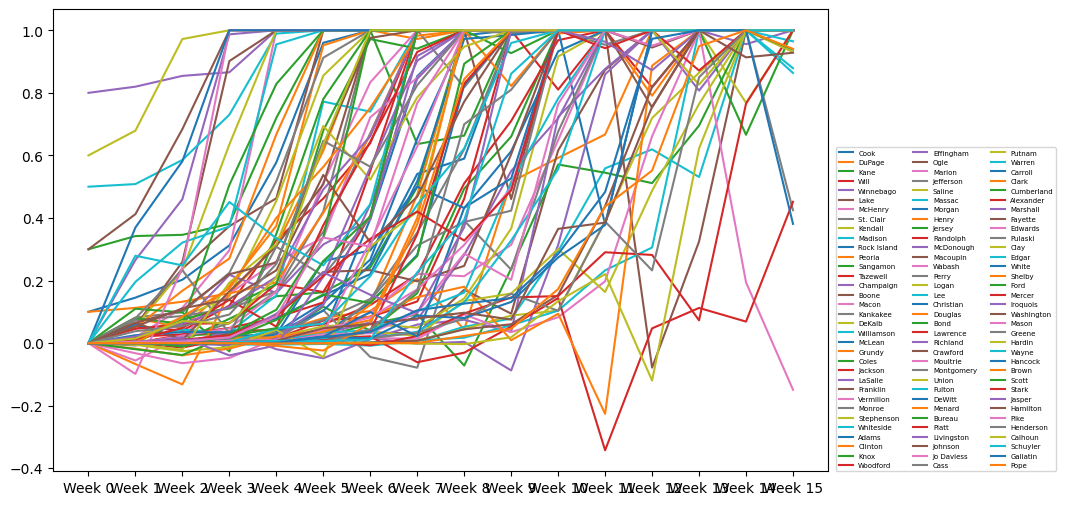

In [4]:
plt.figure(figsize=(10,6))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=5, ncol=3)
plt.show()

In [5]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [6]:
def make_network_heat(week):
    week = f'Week {week}'
#     min_value = simulation_df[week].min()
#     max_value = simulation_df[week].max()  # This makes the scale variable for each chart
    max_value = 1  # This keeps the scale constant 
    min_value = 0
    cmap = matplotlib.colormaps['YlOrRd']

    node_colors = {}
    for node in CG.nodes():
        value = simulation_df.loc[simulation_df['County'] == node.name, week].iloc[0]
        normalized_value = (value - min_value) / (max_value - min_value)
        node_colors[node.name] = cmap(normalized_value)

    labels = {node: handler[node.name].name for node in CG.nodes()}
    fig, ax = plt.subplots(figsize=(10, 15))
    node_positions = {node: [node.centroid.x, node.centroid.y] for node in CG.nodes()}
    nx.draw(CG, 
            pos=node_positions,
            ax=ax, 
            node_color=[node_colors.get(node.name, 'gray') for node in CG.nodes()],
            node_size=1500, )

    nx.draw_networkx_labels(CG, 
                            pos=node_positions, 
                            labels=labels,
                            font_size=6, 
                            ax=ax,
                           font_color='k')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
    sm.set_array([])
    sub_ax = plt.axes([0.96, 0.55, 0.02, 0.3])
    plt.colorbar(sm, cax=sub_ax)
    plt.show()

In [7]:
widgets.interact(make_network_heat,
    week=widgets.IntSlider(min=0, max=len(simulation_df.columns)-2, step=1, layout=widgets.Layout(width='1000px')),
)

interactive(children=(IntSlider(value=0, description='week', layout=Layout(width='1000px'), max=15), Output())…

<function __main__.make_network_heat(week)>

In [8]:
# This doesn't work very well for me since the page keeps re-centering

play = widgets.interact(make_network_heat, 
    week=widgets.Play( value=0,
                        min=0,
                        max=len(simulation_df.columns) - 2,
                        step=1,
                        interval=500,
                        disabled=False
                    ))

interactive(children=(Play(value=0, description='week', interval=500, max=15), Output()), _dom_classes=('widge…

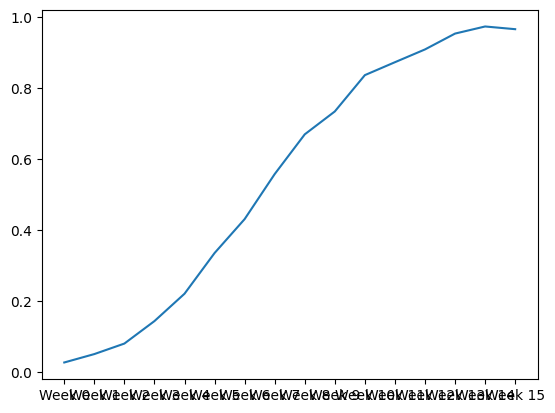

In [9]:
avg_df = visual_df.mean(axis=1)
plt.plot(avg_df.index, avg_df.iloc[0:, ])

# Repeating the Simulation and Plotting the Results

In [10]:
sims_run = 200
sim_weeks = 15
sim_list = []
for i in range(0, sims_run):  # Use this to change the number of simulations you want
    df = invasion_main(sim_weeks)
    sim_list.append(df)  # I did not know that you could put DF's in a list

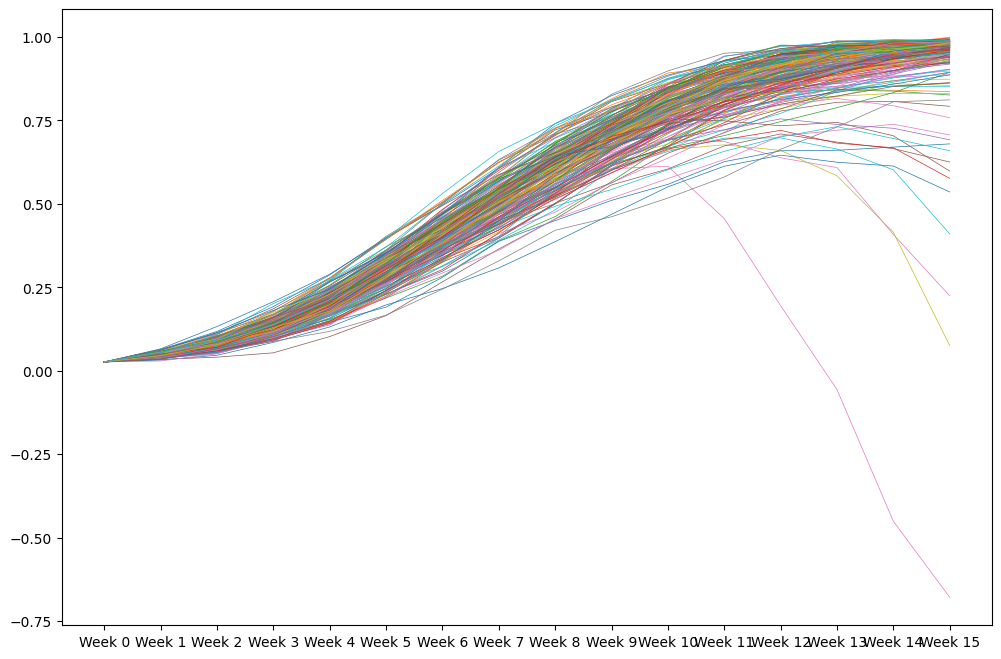

In [11]:
plt.figure(figsize=(12,8))

def make_average_graphs(df):
    vis_df = make_visual_df(df)
    avg_df = vis_df.mean(axis=1)
    plt.plot(avg_df.index, 
             avg_df.iloc[0:, ],
             linewidth=0.5)

for sim in sim_list:
    make_average_graphs(sim)